# Sport Classification
## Using EfficientNet

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

# GPU set up
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Input, MaxPooling2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
target_size = (299, 299)
batch_size = 64

data_gen_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

data_gen = ImageDataGenerator()
train_data = data_gen_aug.flow_from_directory('Data/train', target_size=target_size, batch_size=batch_size, 
                                         class_mode='categorical')

valid_data = data_gen.flow_from_directory('Data/valid', target_size=target_size, batch_size=batch_size,
                                         class_mode='categorical')

test_data = data_gen.flow_from_directory('Data/test', target_size=target_size, batch_size=batch_size,
                                         class_mode='categorical')

class_indices = train_data.class_indices
indicies_class = list(class_indices.keys())
num_classes = len(class_indices)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [5]:
freq = [0 for _ in range(num_classes)]

cnt = 0
for x, y in train_data:
    if cnt >= train_data.n: break
    for b in np.argmax(y, axis=-1):
        print(f'\r%{cnt * 100 / train_data.n : .2f}', end='')
        freq[b] += 1
        cnt += 1
print('\r ', end='')
print(class_indices)

 {'air hockey': 0, 'ampute football': 1, 'archery': 2, 'arm wrestling': 3, 'axe throwing': 4, 'balance beam': 5, 'barell racing': 6, 'baseball': 7, 'basketball': 8, 'baton twirling': 9, 'bike polo': 10, 'billiards': 11, 'bmx': 12, 'bobsled': 13, 'bowling': 14, 'boxing': 15, 'bull riding': 16, 'bungee jumping': 17, 'canoe slamon': 18, 'cheerleading': 19, 'chuckwagon racing': 20, 'cricket': 21, 'croquet': 22, 'curling': 23, 'disc golf': 24, 'fencing': 25, 'field hockey': 26, 'figure skating men': 27, 'figure skating pairs': 28, 'figure skating women': 29, 'fly fishing': 30, 'football': 31, 'formula 1 racing': 32, 'frisbee': 33, 'gaga': 34, 'giant slalom': 35, 'golf': 36, 'hammer throw': 37, 'hang gliding': 38, 'harness racing': 39, 'high jump': 40, 'hockey': 41, 'horse jumping': 42, 'horse racing': 43, 'horseshoe pitching': 44, 'hurdles': 45, 'hydroplane racing': 46, 'ice climbing': 47, 'ice yachting': 48, 'jai alai': 49, 'javelin': 50, 'jousting': 51, 'judo': 52, 'lacrosse': 53, 'log ro

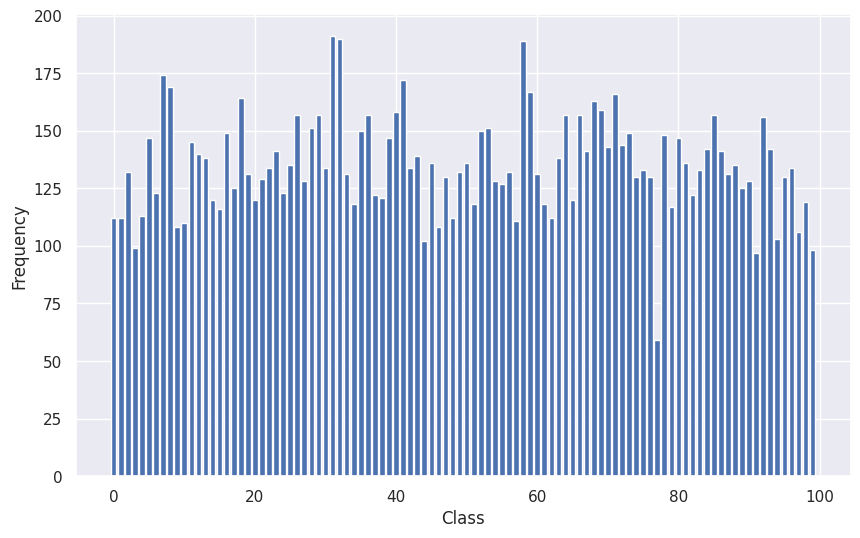

In [6]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.bar(range(100), freq);
plt.xlabel('Class');
plt.ylabel('Frequency');

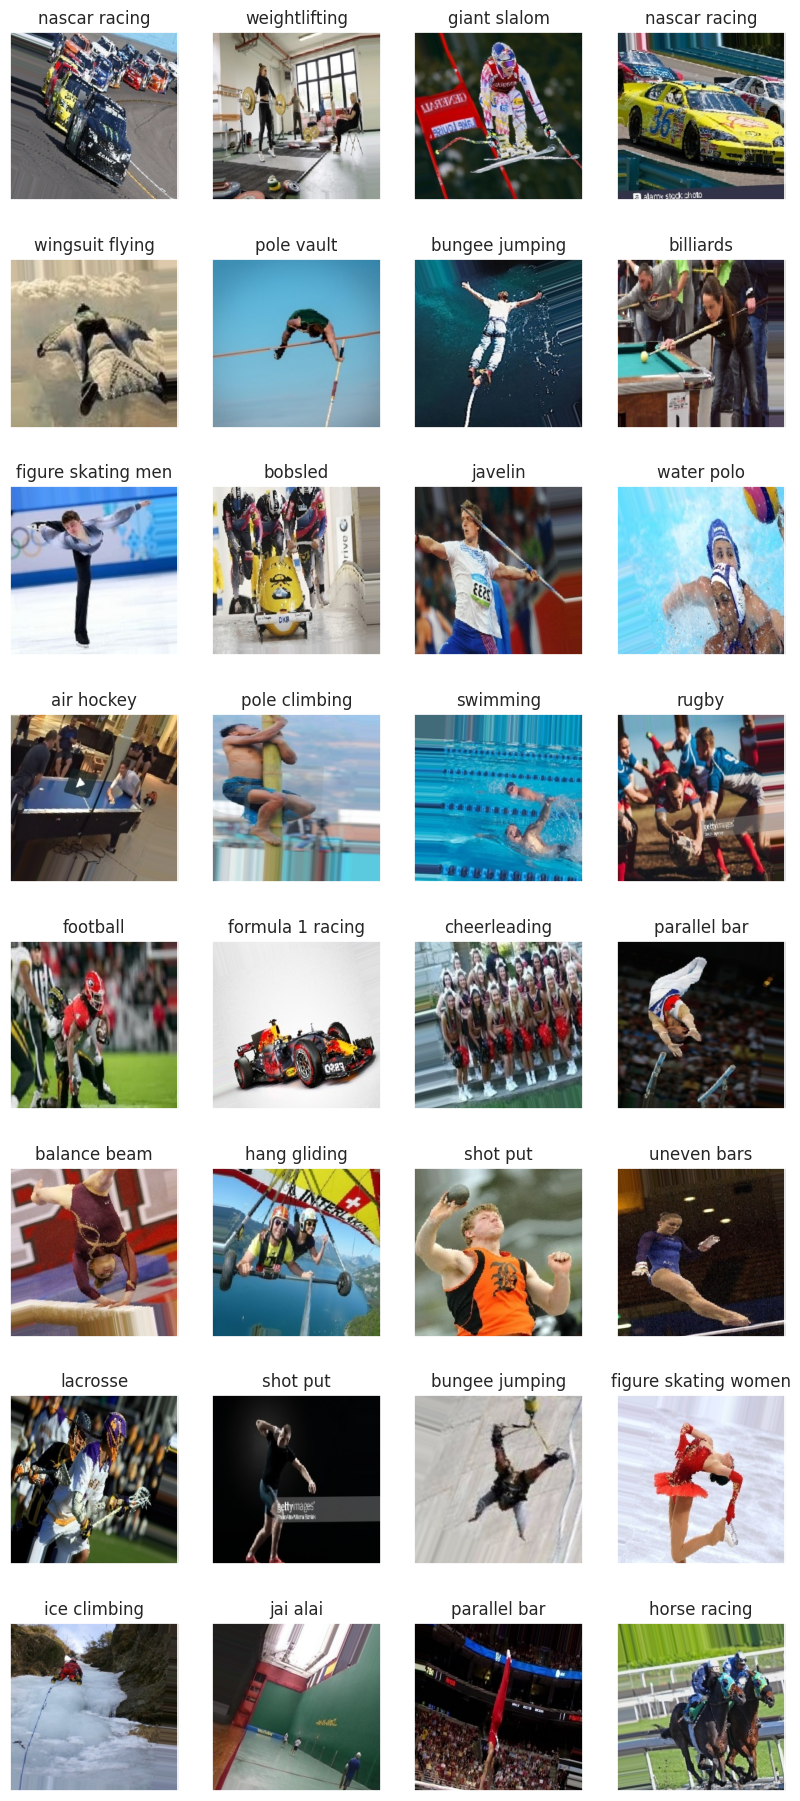

In [7]:
x, y = next(train_data)
y = np.argmax(y, axis=-1)
fig, ax = plt.subplots(8, 4, figsize=(10, 20))
cnt = 0
for a in ax.flatten():
    a.grid(False)
    a.tick_params('both', bottom=False, labelbottom=False, left=False, labelleft=False)
    a.imshow(x[cnt] / 255.0)
    _class = indicies_class[y[cnt]]
    a.set_title(_class)
    cnt += 1
    
fig.subplots_adjust(top=1)

## Model

In [8]:
# Use transfer learning
base_model = tf.keras.applications.EfficientNetB3(include_top=False, input_shape=target_size + (3, ), drop_connect_rate=0)
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 299, 299, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 299, 299, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 299, 299, 3)          0         ['normalization[0

In [9]:
def get_base_model(base_model, layer_name):
    base_model.trainable = False
    inputs = base_model.inputs
    outputs = base_model.get_layer(layer_name).output
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
def get_uncompiled_model(base_model, shape, training=True):
    inputs = Input(shape=shape)
    X = tf.keras.layers.Lambda(lambda x: tf.keras.applications.efficientnet.preprocess_input(x))(inputs)
    X = base_model(X)
    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.2)(X)
    outputs = Dense(units=100, activation='softmax')(X)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
# Defining the model
base_model = get_base_model(base_model, 'top_activation')
model = get_uncompiled_model(base_model, target_size + (3,))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 299, 299, 3)       0         
                                                                 
 model (Functional)          (None, 10, 10, 1536)      10783535  
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 100)               153700    
                                                           

In [12]:
class F1_Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1_Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)
            
    def result(self):
        self.f1.assign(2 * (self.precision.result() * self.recall.result()) / (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))
        return self.f1
    
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [13]:
# Compile the model
optimizer = tf.optimizers.RMSprop()
loss = tf.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', F1_Score()])

In [14]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
211/211 [==============================] - 199s 890ms/step - loss: 1.5945 - accuracy: 0.7042 - f1_score: 0.4963 - val_loss: 0.4822 - val_accuracy: 0.8900 - val_f1_score: 0.8578
Epoch 2/5
211/211 [==============================] - 187s 886ms/step - loss: 0.4777 - accuracy: 0.8902 - f1_score: 0.8659 - val_loss: 0.2630 - val_accuracy: 0.9340 - val_f1_score: 0.9252
Epoch 3/5
211/211 [==============================] - 188s 890ms/step - loss: 0.3271 - accuracy: 0.9217 - f1_score: 0.9131 - val_loss: 0.2030 - val_accuracy: 0.9520 - val_f1_score: 0.9414
Epoch 4/5
211/211 [==============================] - 188s 890ms/step - loss: 0.2601 - accuracy: 0.9359 - f1_score: 0.9314 - val_loss: 0.1796 - val_accuracy: 0.9460 - val_f1_score: 0.9444
Epoch 5/5
211/211 [==============================] - 189s 896ms/step - loss: 0.2151 - accuracy: 0.9486 - f1_score: 0.9450 - val_loss: 0.1625 - val_accuracy: 0.9520 - val_f1_score: 0.9505


## Evaluation on training

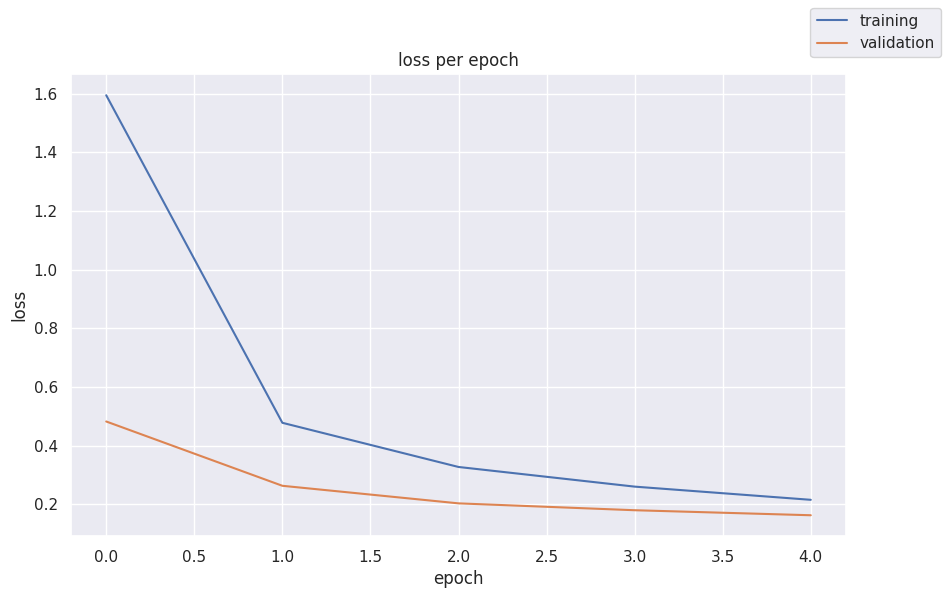

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.legend();

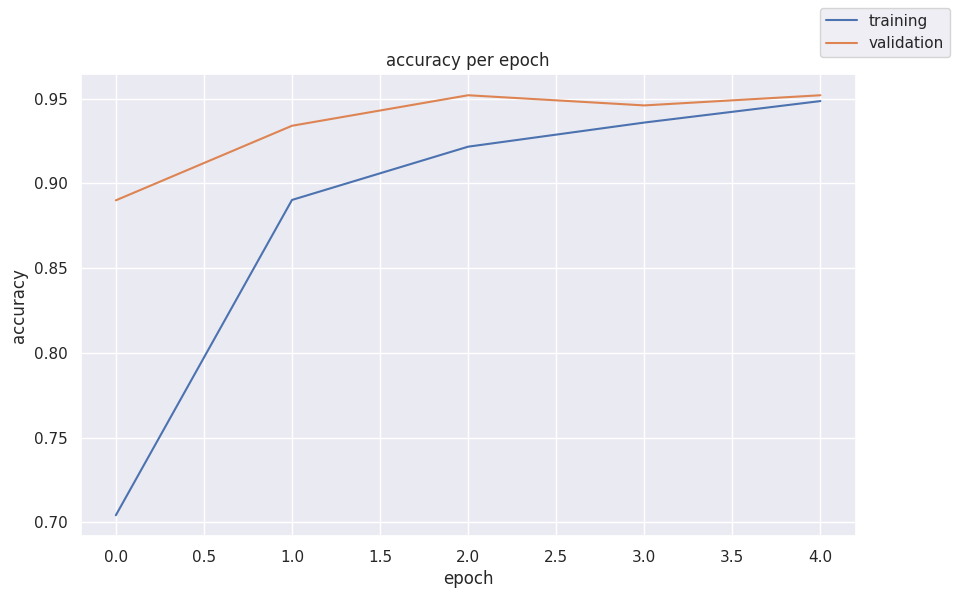

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.epoch, history.history['accuracy'], label='training')
ax.plot(history.epoch, history.history['val_accuracy'], label='validation')
ax.set_title('accuracy per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.legend();

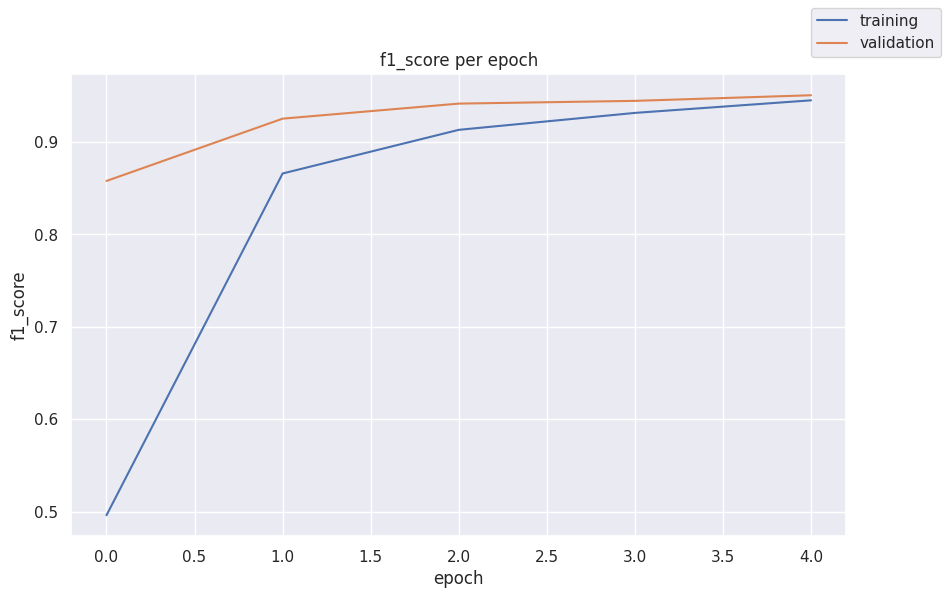

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.epoch, history.history['f1_score'], label='training')
ax.plot(history.epoch, history.history['val_f1_score'], label='validation')
ax.set_title('f1_score per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('f1_score')
fig.legend();

In [18]:
y_true = np.array([0 for _ in range(valid_data.n)])
y_pred = np.array([0 for _ in range(valid_data.n)])
cnt = 0
for x, y in valid_data:
    y_true[cnt : cnt + y.shape[0]] = np.argmax(y, axis=-1)
    y_pred[cnt : cnt + y.shape[0]] = np.argmax(model.predict(x, verbose=0), axis=-1)
    cnt += y.shape[0]
    print(f'\r{cnt}', end='')
    if cnt >= valid_data.n: break

500

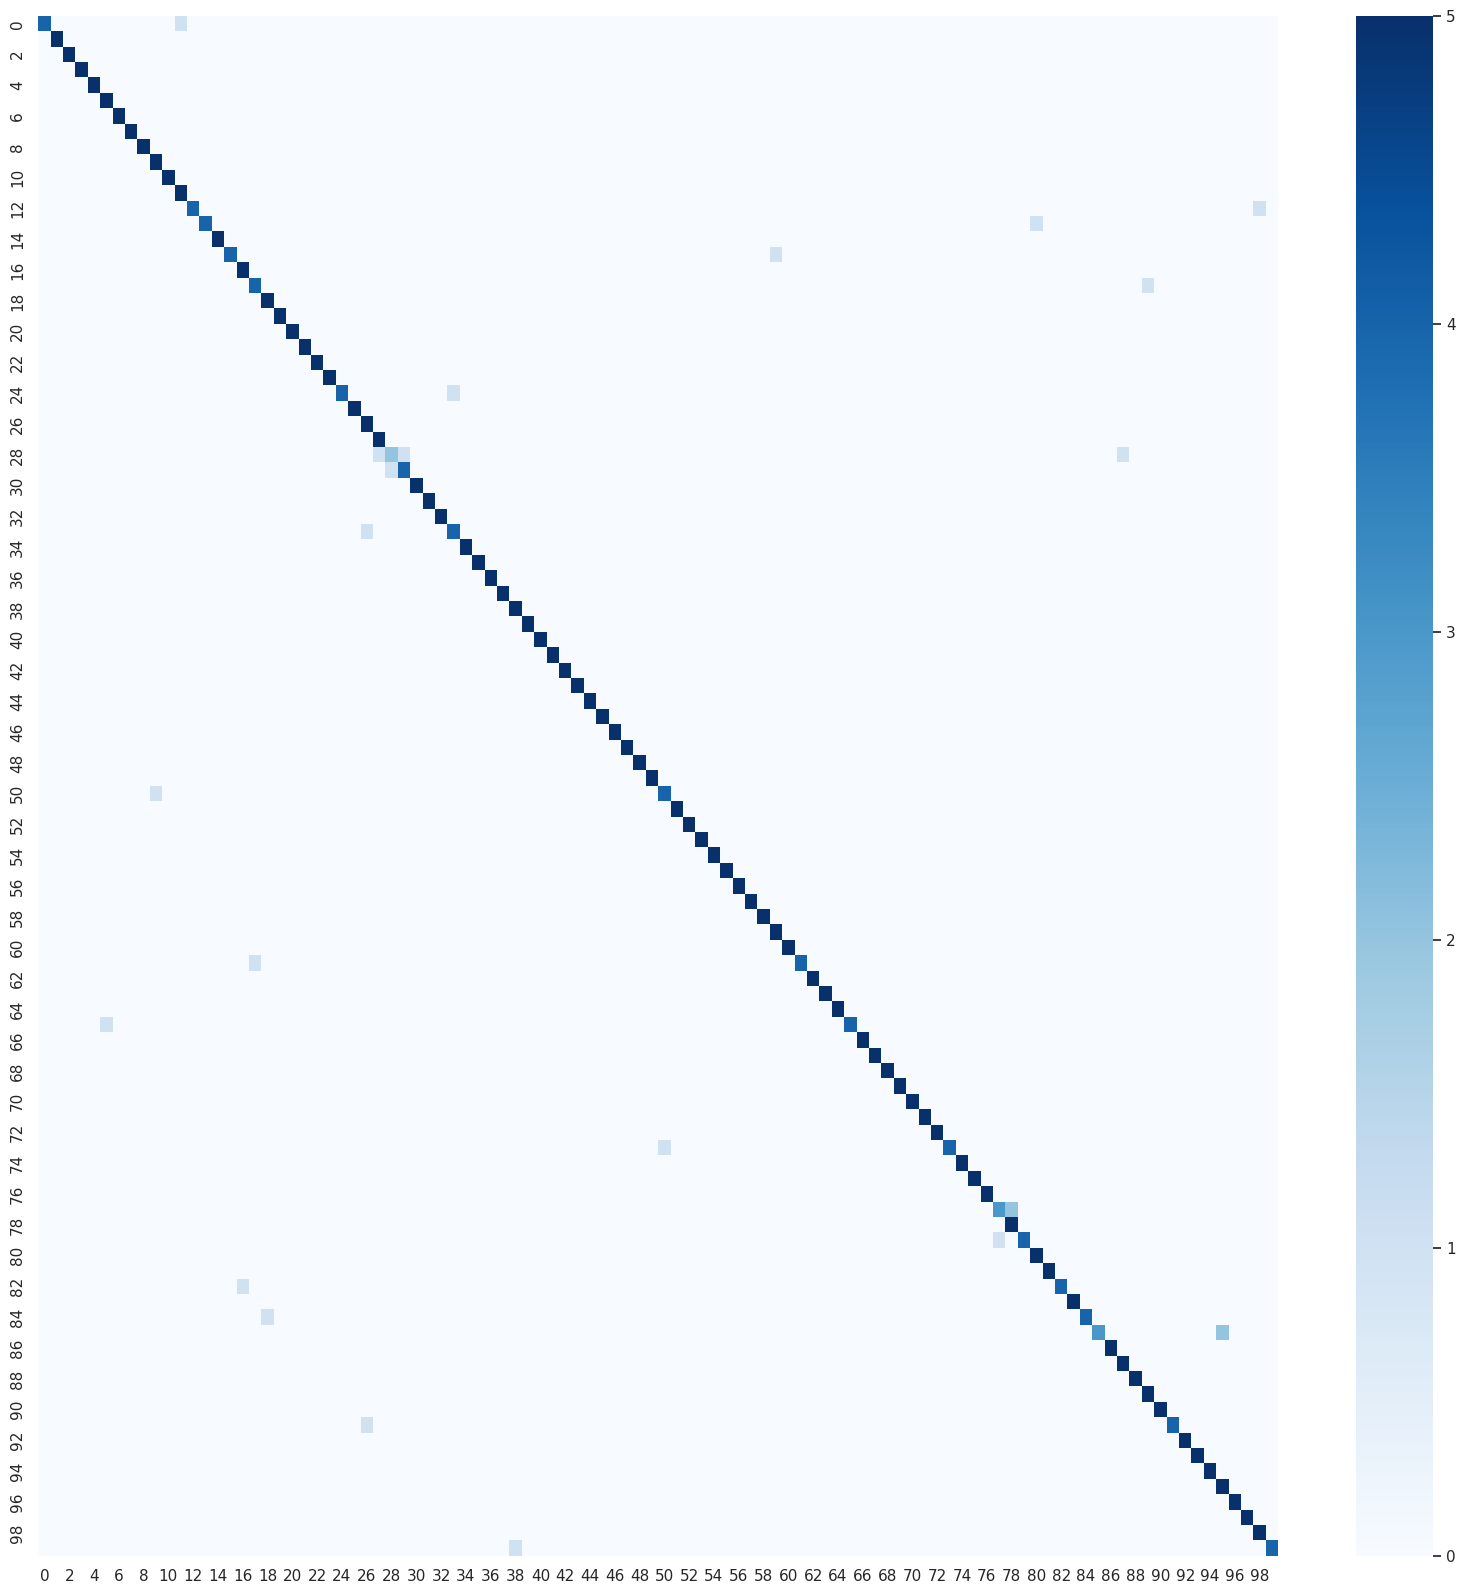

In [19]:
plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, cmap='Blues')

In [20]:
report = classification_report(y_true, y_pred, zero_division=True)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       0.83      1.00      0.91         5
          12       1.00      0.80      0.89         5
          13       1.00      0.80      0.89         5
          14       1.00      1.00      1.00         5
          15       1.00      0.80      0.89         5
          16       0.83      1.00      0.91         5
          17       0.80    

## Fine Tuning

In [21]:
print(f'Number of layers for the base model is {len(model.layers[2].layers)}')

Number of layers for the base model is 366


In [22]:
for i, l in enumerate(model.layers[2].layers):
    print(f'{i:<4} : {l.name}')

0    : input_1
1    : rescaling
2    : normalization
3    : rescaling_1
4    : stem_conv_pad
5    : stem_conv
6    : stem_bn
7    : stem_activation
8    : block1a_dwconv
9    : block1a_bn
10   : block1a_activation
11   : block1a_se_squeeze
12   : block1a_se_reshape
13   : block1a_se_reduce
14   : block1a_se_expand
15   : block1a_se_excite
16   : block1a_project_conv
17   : block1a_project_bn
18   : block1b_dwconv
19   : block1b_bn
20   : block1b_activation
21   : block1b_se_squeeze
22   : block1b_se_reshape
23   : block1b_se_reduce
24   : block1b_se_expand
25   : block1b_se_excite
26   : block1b_project_conv
27   : block1b_project_bn
28   : block1b_add
29   : block2a_expand_conv
30   : block2a_expand_bn
31   : block2a_expand_activation
32   : block2a_dwconv_pad
33   : block2a_dwconv
34   : block2a_bn
35   : block2a_activation
36   : block2a_se_squeeze
37   : block2a_se_reshape
38   : block2a_se_reduce
39   : block2a_se_expand
40   : block2a_se_excite
41   : block2a_project_conv
42   : 

In [23]:
fine_tune_at = 353
model.trainable = True
for l in model.layers[2].layers[:fine_tune_at]:
    l.trainable = False

for l in model.layers[2].layers[fine_tune_at:]:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = False
        print(f'{l.name:<20} changed to inference mode')

block7b_bn           changed to inference mode
block7b_project_bn   changed to inference mode
top_bn               changed to inference mode


In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 299, 299, 3)       0         
                                                                 
 model (Functional)          (None, 10, 10, 1536)      10783535  
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 100)               153700    
                                                           

In [34]:
# Recompile the model
def lr_decay(epoch):
    return 1e-4 if epoch >= 2 else 1e-3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_decay)

optimizer = tf.optimizers.RMSprop(learning_rate=1e-3)
loss = tf.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', F1_Score()])

In [35]:
fine_tune_history = model.fit(train_data, epochs=5, validation_data=valid_data, callbacks=[lr_schedule])

Epoch 1/5
211/211 [==============================] - 196s 892ms/step - loss: 0.0605 - accuracy: 0.9824 - f1_score: 0.9821 - val_loss: 0.1371 - val_accuracy: 0.9540 - val_f1_score: 0.9539 - lr: 0.0010
Epoch 2/5
211/211 [==============================] - 187s 884ms/step - loss: 0.0470 - accuracy: 0.9861 - f1_score: 0.9859 - val_loss: 0.1227 - val_accuracy: 0.9680 - val_f1_score: 0.9690 - lr: 0.0010
Epoch 3/5
211/211 [==============================] - 188s 889ms/step - loss: 0.0218 - accuracy: 0.9938 - f1_score: 0.9938 - val_loss: 0.0977 - val_accuracy: 0.9740 - val_f1_score: 0.9739 - lr: 1.0000e-04
Epoch 4/5
211/211 [==============================] - 187s 887ms/step - loss: 0.0157 - accuracy: 0.9959 - f1_score: 0.9959 - val_loss: 0.0954 - val_accuracy: 0.9700 - val_f1_score: 0.9710 - lr: 1.0000e-04
Epoch 5/5
211/211 [==============================] - 187s 886ms/step - loss: 0.0142 - accuracy: 0.9957 - f1_score: 0.9957 - val_loss: 0.0891 - val_accuracy: 0.9720 - val_f1_score: 0.9720 - lr:

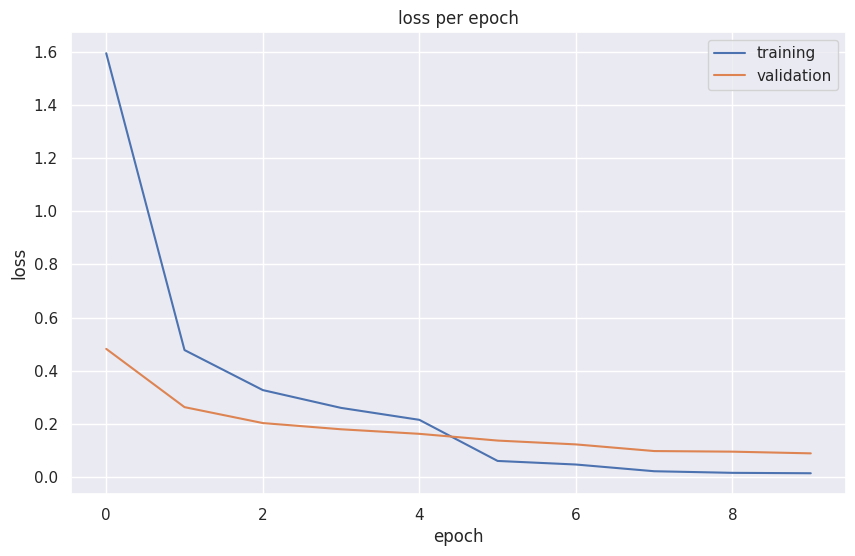

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
epochs = list(range(len(history.epoch) + len(fine_tune_history.epoch)))
ax.plot(epochs, history.history['loss'] + fine_tune_history.history['loss'], label='training')
ax.plot(epochs, history.history['val_loss'] + fine_tune_history.history['val_loss'], label='validation')
ax.set_title('loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend();

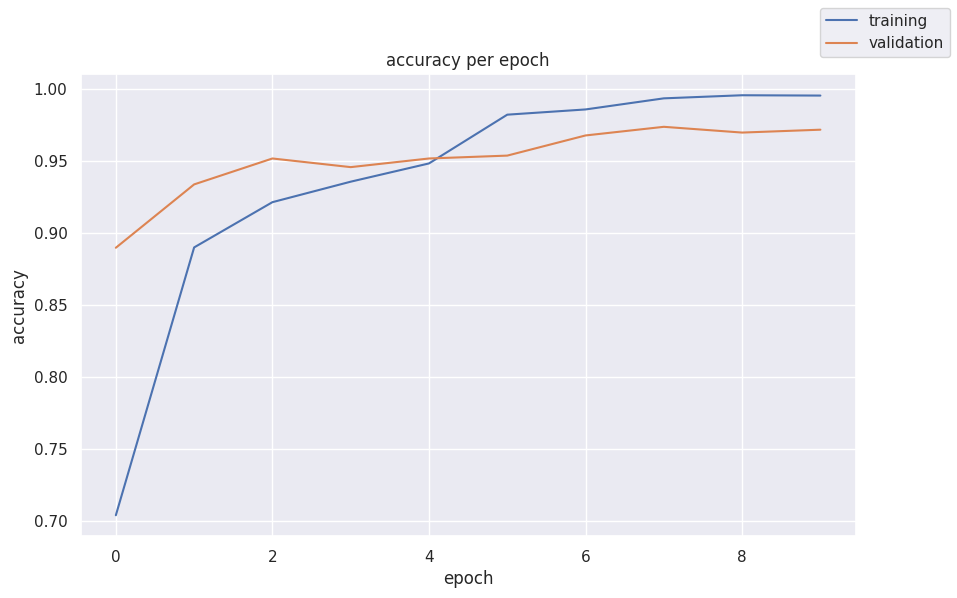

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
epochs = list(range(len(history.epoch) + len(fine_tune_history.epoch)))
ax.plot(epochs, history.history['accuracy'] + fine_tune_history.history['accuracy'], label='training')
ax.plot(epochs, history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='validation')
ax.set_title('accuracy per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.legend();

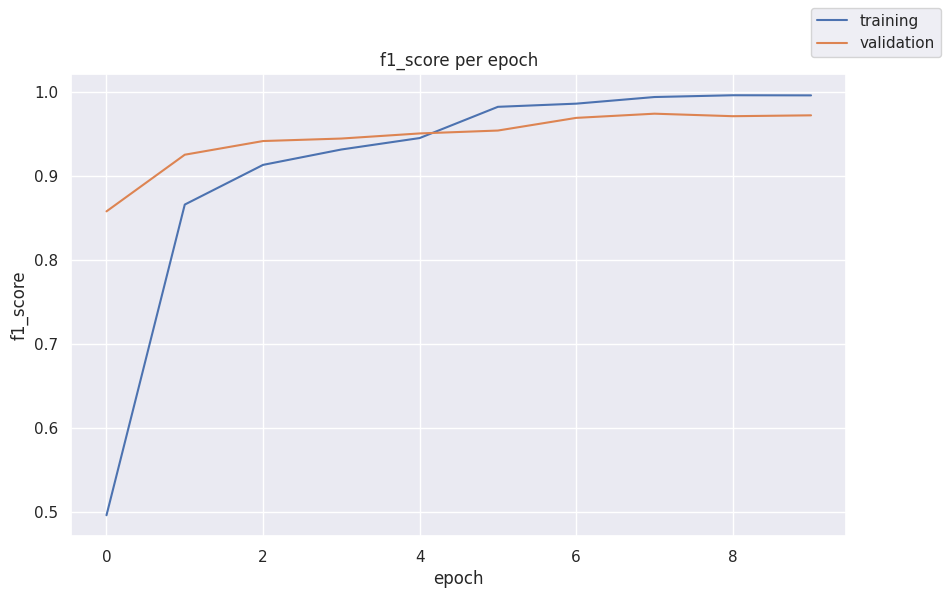

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
epochs = list(range(len(history.epoch) + len(fine_tune_history.epoch)))
ax.plot(epochs, history.history['f1_score'] + fine_tune_history.history['f1_score'], label='training')
ax.plot(epochs, history.history['val_f1_score'] + fine_tune_history.history['val_f1_score'], label='validation')
ax.set_title('f1_score per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('f1_score')
fig.legend();

In [39]:
y_true = np.array([0 for _ in range(test_data.n)])
y_pred = np.array([0 for _ in range(test_data.n)])
cnt = 0
for x, y in test_data:
    y_true[cnt : cnt + y.shape[0]] = np.argmax(y, axis=-1)
    y_pred[cnt : cnt + y.shape[0]] = np.argmax(model.predict(x, verbose=0), axis=-1)
    cnt += y.shape[0]
    print(f'\r{cnt}', end='')
    if cnt >= valid_data.n: break

500

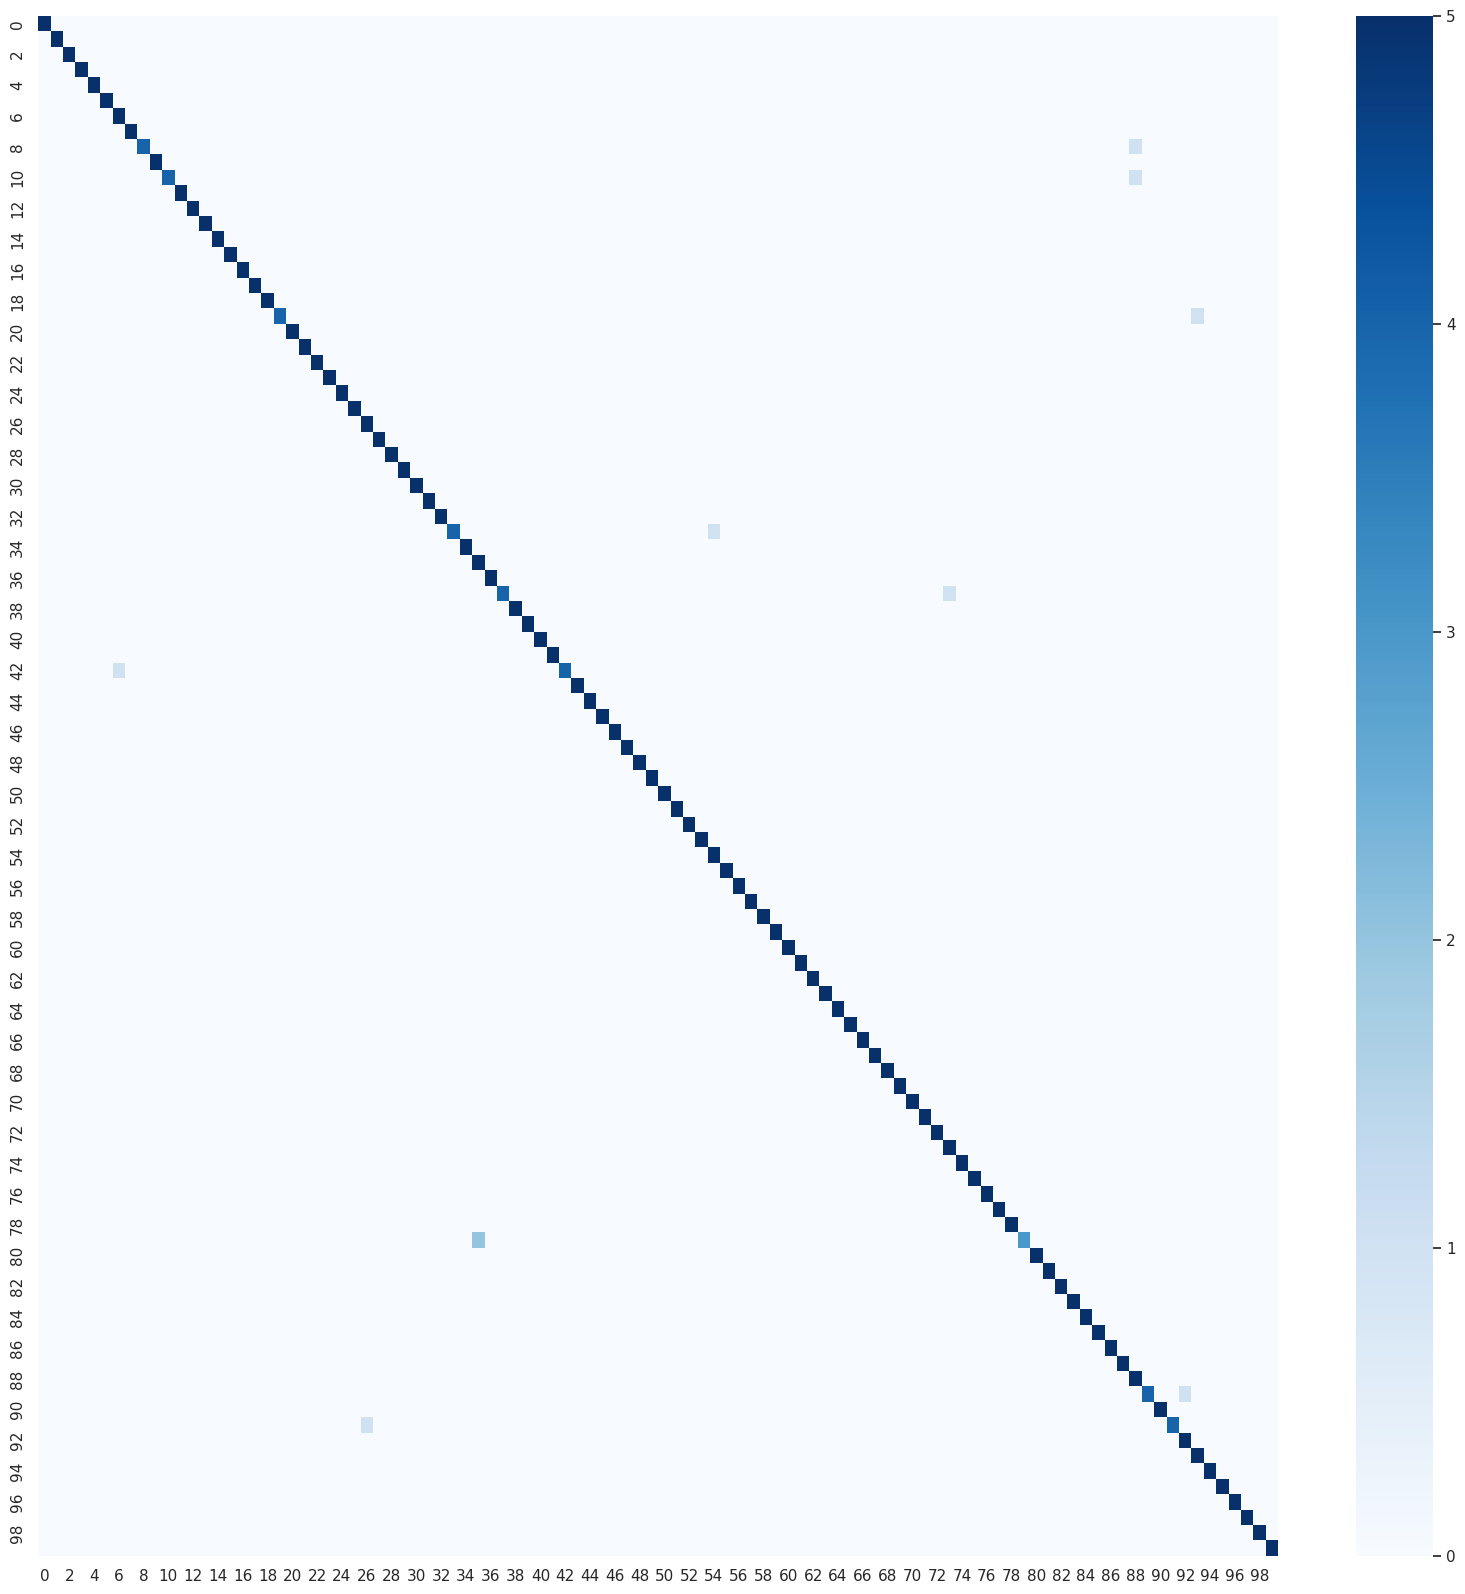

In [40]:
plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, cmap='Blues')

In [41]:
report = classification_report(y_true, y_pred, zero_division=True)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      0.80      0.89         5
           9       1.00      1.00      1.00         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

In [44]:
model.save('efficientnet_98f1_score.keras')

## Summary
The model is fit perfectly, let's see if we can do better
Ideas are

- Train more
- More complex model should be able to help with underfitting
- Intensifing data augmentation should help for more generalization